In [1]:

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from data_handler import DataHandler
from week_planner import WeekPlanner

Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py


/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

dataHandler = DataHandler(
influx_id="localhost",
db_name="smart_home_zukalovi",
db_username="root",
db_password="root",
relay_entity_id="shelly1pm_84cca8b07eae",
relay_power_entity_id="shelly1pm_84cca8b07eae_power",
tmp_boiler_case_entity_id="esphome_web_c771e8_tmp3",
tmp_output_water_entity_id="esphome_web_c771e8_ntc_temperature_b_constant_2",
start_of_data=datetime(2024, 3, 1, 0, 0, 0, 0))






In [4]:
data = dataHandler.get_data_for_high_tarif_info()


water_flow
SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2024-02-22T10:49:46Z' AND time < '2024-03-07T10:49:46Z' GROUP BY time(5s) FILL(0)
water_temperature
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2024-02-22T10:49:46Z' AND time < '2024-03-07T10:49:46Z' AND "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2' GROUP BY time(5s) FILL(null)
temperature
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-22T10:49:46Z' AND time < '2024-03-07T10:49:46Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(5s) FILL(null)
humidity
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-22T10:49:46Z' AND time < '2024-03-07T10:49:46Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(5s) FILL(null)
wind_spe

In [49]:
print(data['boiler_relay_status'])

2024-02-22 10:49:45   NaN
2024-02-22 10:49:50   NaN
2024-02-22 10:49:55   NaN
2024-02-22 10:50:00   NaN
2024-02-22 10:50:05   NaN
                       ..
2024-03-07 10:49:25   NaN
2024-03-07 10:49:30   NaN
2024-03-07 10:49:35   NaN
2024-03-07 10:49:40   NaN
2024-03-07 10:49:45   NaN
Name: boiler_relay_status, Length: 241921, dtype: float64


In [70]:
data_resampled = data.resample('10T').max()
data_resampled = data_resampled['boiler_relay_status']
data_resampled = data_resampled.notna().astype(int)
data_resampled = data_resampled.resample('30T').sum() * 10
print(data_resampled)
# group by weekday and hour and minute and calculate max
grouped = data_resampled.groupby([data_resampled.index.weekday, data_resampled.index.hour, data_resampled.index.minute]).mean()

# not null values to 1, null as 0
df_reset = grouped.reset_index()
df_reset['time'] = df_reset['level_1'].astype(str) + ':' + df_reset['level_2'].astype(str)
df_reset['time'] = pd.to_datetime(df_reset['time'], format='%H:%M').dt.time
df_reset['weekday'] = df_reset['level_0']
df_reset['unavailable_minutes'] = abs(30 - df_reset['boiler_relay_status'])

df_reset = df_reset.drop(columns=['level_0', 'level_1', 'level_2', 'boiler_relay_status'])





2024-02-22 10:30:00    10
2024-02-22 11:00:00    30
2024-02-22 11:30:00    30
2024-02-22 12:00:00    30
2024-02-22 12:30:00    30
                       ..
2024-03-07 08:30:00    20
2024-03-07 09:00:00     0
2024-03-07 09:30:00     0
2024-03-07 10:00:00     0
2024-03-07 10:30:00     0
Freq: 30T, Name: boiler_relay_status, Length: 673, dtype: int64


In [71]:
datetime_sunday_evening = datetime(2024,3,3,13,0,0)
actual_time = datetime_sunday_evening.time()
actual_schedule = df_reset[(df_reset['time'] > actual_time) & (df_reset['weekday'] >= datetime_sunday_evening.weekday())]
# get first 6*12 rows
actual_schedule = actual_schedule.head(2*12)

if (len(actual_schedule) < 2*12):
    #concat actual schedule with beggining of df_reset
    actual_schedule = pd.concat([actual_schedule, df_reset.head(6*12 - len(actual_schedule))])
    

    

In [57]:
print(actual_schedule)

     boiler_relay_status      time  weekday
315                  5.0  13:30:00        6
316                  5.0  14:00:00        6
317                  5.0  14:30:00        6
318                  5.0  15:00:00        6
319                  5.0  15:30:00        6
..                   ...       ...      ...
46                   5.0  23:00:00        0
47                   5.0  23:30:00        0
48                   5.0  00:00:00        1
49                   5.0  00:30:00        1
50                   5.0  01:00:00        1

[72 rows x 3 columns]


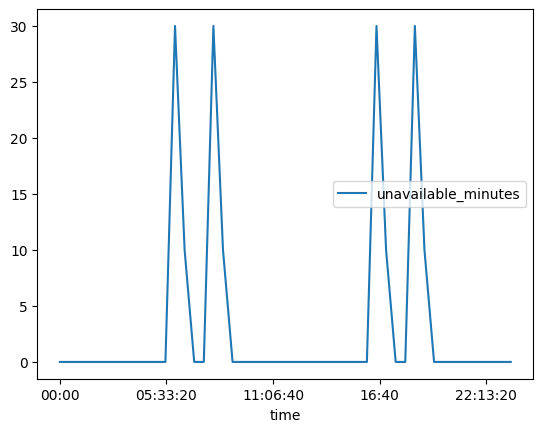

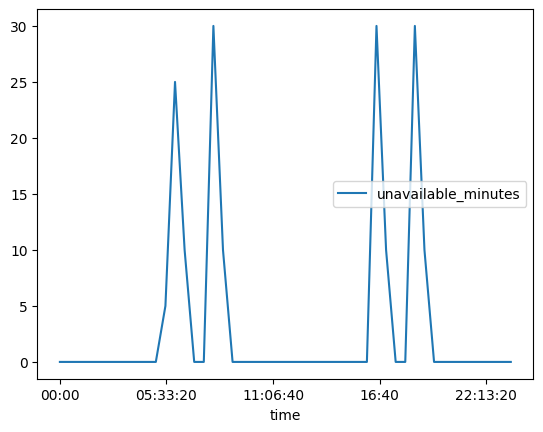

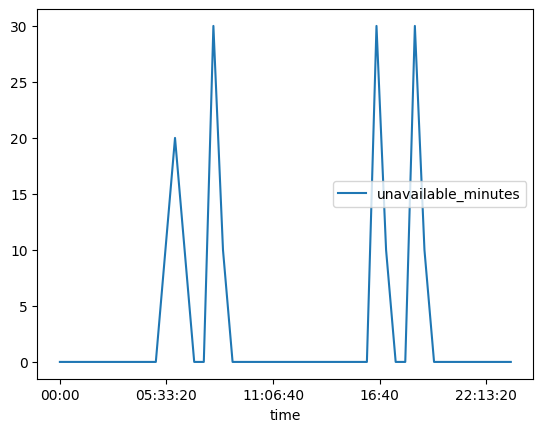

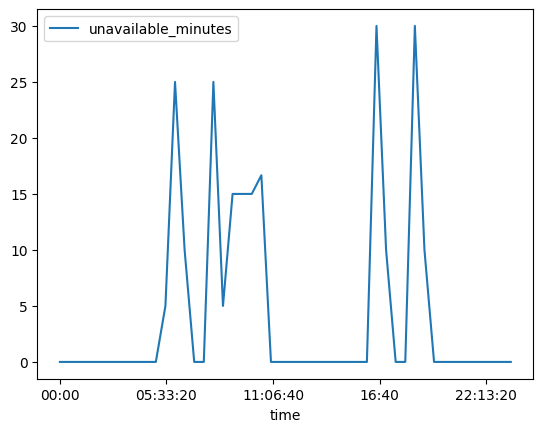

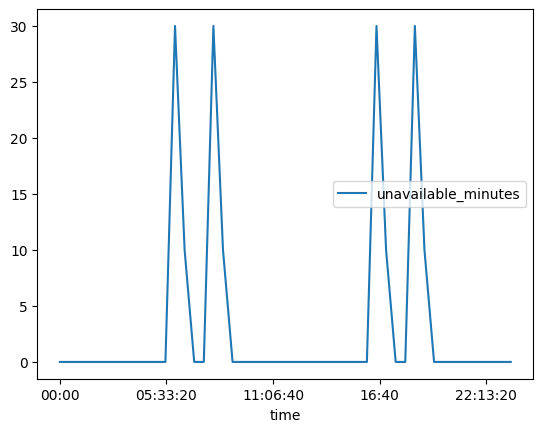

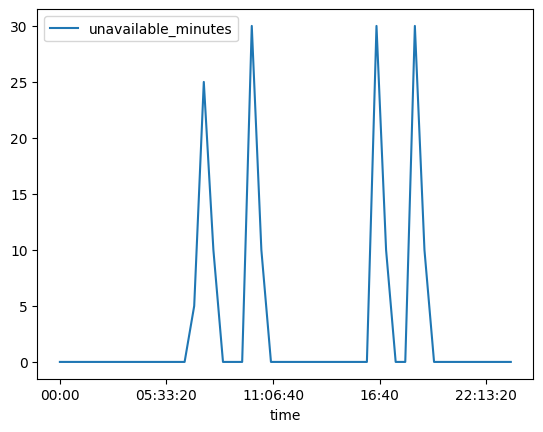

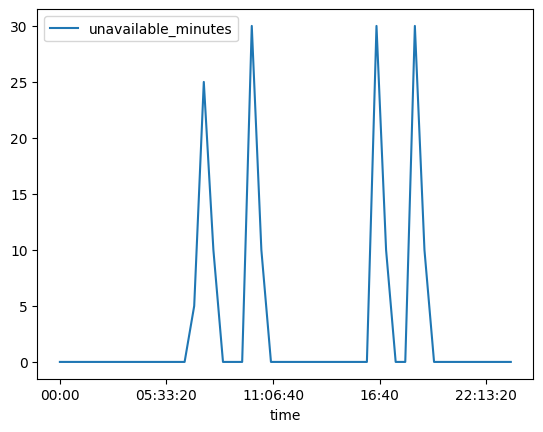

In [73]:
for i in range(0,7):
    df_day = df_reset[df_reset['weekday'] == i]

    df_day.plot(x='time', y='unavailable_minutes', kind='line')

<AxesSubplot:xlabel='time'>

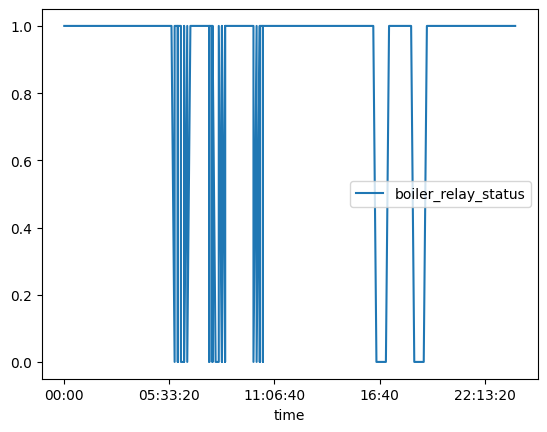

In [7]:
# make a dictionary of weekdays with list of data about null value of boiler_relay_status
#resample to 10 minutes
data = data.resample('10T').max()
data_dict = {}

for i in range(7):
    data_dict[i] = data[data.index.weekday == i]
    data_dict[i] = data_dict[i].sort_values(by='time')

water_flow
SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2024-02-22T10:45:19Z' AND time < '2024-03-07T10:45:19Z' GROUP BY time(5s) FILL(0)
water_temperature
SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2024-02-22T10:45:19Z' AND time < '2024-03-07T10:45:19Z' AND "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2' GROUP BY time(5s) FILL(null)
temperature
SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-22T10:45:19Z' AND time < '2024-03-07T10:45:19Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(5s) FILL(null)
humidity
SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2024-02-22T10:45:19Z' AND time < '2024-03-07T10:45:19Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(5s) FILL(null)
wind_spe

KeyError: 'time'

In [6]:
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 4, 23, 59, 59)
data = dataHandler.get_data_for_prediction(forecast_begin_date, forecast_end_date)
data_train = dataHandler.get_data_for_training_model(start_of_data, end_of_training_data)

/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [13]:
# data to df
df = pd.DataFrame(data, columns=["longtime_mean", "weekday_sin", "weekday_cos", "hour_sin", "hour_cos", "minute_sin", "minute_cos"])
df.index = pd.to_datetime(df.index)
# crate a dict with nan intervals of 

------------------------------------------------------

initializing of WeekPlanner

------------------------------------------------------

------------------------------------------------------

initializing of TimeHandler

------------------------------------------------------



AttributeError: 'DataFrame' object has no attribute 'tmp1'

                           longtime_mean  weekday_sin  weekday_cos  hour_sin  \
2023-11-01 00:00:00+00:00       2.604167     0.974928    -0.222521  0.000000   
2023-11-01 00:30:00+00:00       2.604167     0.974928    -0.222521  0.000000   
2023-11-01 01:00:00+00:00       2.604167     0.974928    -0.222521  0.258819   
2023-11-01 01:30:00+00:00       2.604167     0.974928    -0.222521  0.258819   
2023-11-01 02:00:00+00:00       2.604167     0.974928    -0.222521  0.500000   
...                                  ...          ...          ...       ...   
2024-01-04 21:30:00+00:00      10.152372     0.433884    -0.900969 -0.707107   
2024-01-04 22:00:00+00:00       2.745363     0.433884    -0.900969 -0.500000   
2024-01-04 22:30:00+00:00       2.608393     0.433884    -0.900969 -0.500000   
2024-01-04 23:00:00+00:00       2.604167     0.433884    -0.900969 -0.258819   
2024-01-04 23:30:00+00:00       2.604167     0.433884    -0.900969 -0.258819   

                           hour_cos    

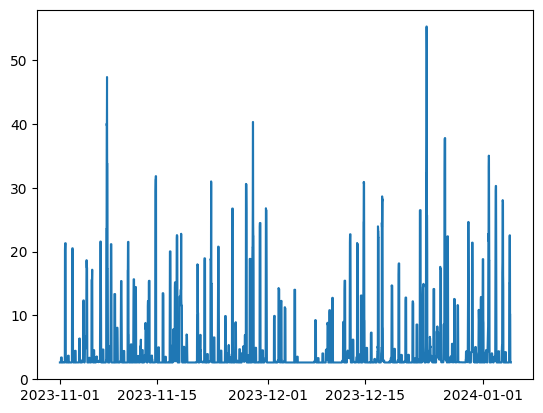

In [5]:

#create a new dataframe from data[0] as columsn and data[1] as index
# data_longtime = data[0].set_index(data[1])
# data_longtime = data_longtime.resample('30T').sum()
data_longtime = data_train[0].set_index(data_train[1])
data_longtime = data_longtime.resample('30T').sum()
print(data_longtime)
plt.plot(data_longtime['longtime_mean'])

In [6]:

forecast = Forecast(dataHandler)
forecast.train_model(begin_of_training=start_of_data, end_of_training=end_of_training_data)
forecast.build_model()
forecast.fit_model()




Epoch 1/70


/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

932/932 [==============================] - 3s 2ms/step - loss: 1.3906 - r2_keras: -133942.9062 - val_loss: 1.6281 - val_r2_keras: -9560754.0000
Epoch 2/70
 75/932 [=>............................] - ETA: 1s - loss: 1.3713 - r2_keras: -472787.0938

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 2s 2ms/step - loss: 0.9245 - r2_keras: -217318.2031 - val_loss: 1.1049 - val_r2_keras: -18829616.0000
Epoch 3/70
932/932 [==============================] - 2s 2ms/step - loss: 0.8204 - r2_keras: -425519.2188 - val_loss: 1.1205 - val_r2_keras: -5942367.5000
Epoch 4/70
932/932 [==============================] - 2s 2ms/step - loss: 0.7193 - r2_keras: -132393.9531 - val_loss: 1.0380 - val_r2_keras: -11541409.0000
Epoch 5/70
932/932 [==============================] - 2s 2ms/step - loss: 0.6786 - r2_keras: -139711.0312 - val_loss: 1.0222 - val_r2_keras: -6066462.5000
Epoch 6/70
932/932 [==============================] - 2s 2ms/step - loss: 0.6769 - r2_keras: -45857.2109 - val_loss: 0.9735 - val_r2_keras: -11027444.0000
Epoch 7/70
932/932 [==============================] - 2s 2ms/step - loss: 0.6592 - r2_keras: -47391.9805 - val_loss: 0.9688 - val_r2_keras: -5949105.5000
Epoch 8/70
932/932 [==============================] - 2s 2ms/step - loss: 0.5713

In [7]:
forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 2, 23, 59, 59)
pred = forecast.get_forecast_next_steps(start_of_data, end_of_training_data)



-----
1/1 [==============================] - 0s 135ms/step


/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 13ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 9ms/step
-----
1/1 [==============================] - 0s 9ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 9ms/step
-----
1/1 [==============================] - 0s 9ms/step
-----
1/1 [=======

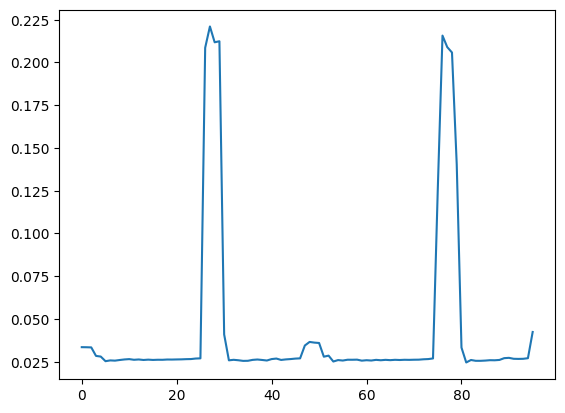

In [26]:
pred['longtime_mean'] = pred['longtime_mean'] / 100
plt.plot(pred['longtime_mean'], label="Predicted")


In [ ]:
# create dataframe with column datetime from now to now+6hours and rows by 30 minutes

forecast_begin_date = datetime(2024, 1, 1, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 4, 23, 59, 59)

df_predict = pd.DataFrame({'datetime': pd.date_range(forecast_begin_date, forecast_end_date, freq='30min')})
df_predict['longtime_mean'] = 0
df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# delete column datetime
df_predict = df_predict.drop(columns='datetime')
df_predict_trans = df_predict.copy()
df_predict_trans[df_predict.columns] = forecast.scaler.transform(df_predict)

predict_gen = forecast.generator(df_predict_trans, 'longtime_mean', 
                lookback = forecast.lookback,
                delay = forecast.delay,
                min_index = 0,
                max_index = None,
                step = 1,
                shuffle = False,
                batch_size = df_predict.shape[0])

(X_2, y_2) = next(predict_gen)
print((X_2.shape))
y_pred_2 = forecast.model.predict(X_2)
y_pred_2_inv = np.concatenate((y_pred_2,np.zeros((y_pred_2.shape[0],forecast.num_of_features))),axis=1)
y_pred_2_inv = forecast.scaler.inverse_transform(y_pred_2_inv)
y_pred_2_inv = y_pred_2_inv[:,0]

plt.plot(y_pred_2_inv, color = 'green', label = 'Predicted data')
plt.plot(y_2, color = 'green', label = 'Predicted data')
plt.show()

In [ ]:
# create a df with datetime and predicted values
df_predicted = pd.DataFrame()
df_predicted['longtime_mean'] = y_pred_2
print(len(y_pred_2))
forecast_begin_date = forecast_begin_date + pd.Timedelta(5, unit='h')
x = pd.date_range(forecast_begin_date , forecast_end_date, freq='30min')
print(x.shape)
df_predicted['datetime'] = pd.date_range(forecast_begin_date , forecast_end_date, freq='30min')

In [11]:
queries = {
            "water_flow": {
                "sql_query": f'SELECT mean("value") AS "water_flow_L_per_hour_mean" FROM "smart_home_formankovi"."autogen"."L/min" WHERE "entity_id"=\'esphome_boiler_temps_current_water_usage\' GROUP BY time(5s) FILL(0)',
                "measurement": "L/min",
            },
            "water_temperature": {
                "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_formankovi"."autogen"."°C" WHERE "entity_id"=\'esphome_boiler_temps_ntc_temperature_b_constant\' GROUP BY time(5s) FILL(previous)',
                "measurement": "°C",},
            "boiler_wattage": {
                "sql_query": f'SELECT mean("value") AS "boiler_wattage_mean" FROM "smart_home_formankovi"."autogen"."W" WHERE "entity_id"=\'shelly1pm_34945475a969_power\' GROUP BY time(5s) FILL(0)',
                "measurement": "W",
            },
            }
            # "boiler_relay_status": {"sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "smart_home_formankovi"."autogen"."state" WHERE time > {time_interval_left} AND time < {time_interval_right} AND "entity_id"=\'{self.relay_entity_id}\' GROUP BY time(1h) FILL(previous)',
            #                        "measurement": "state"},
        
from influxdb import DataFrameClient
dataframe_client = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi'
        )

df_all_list = []
# iterate over key an value in data_formankovi
for key, value in queries.items():
    # get data from influxdb
    result = dataframe_client.query(value["sql_query"])[
        value["measurement"]
    ]
    
    df = pd.DataFrame(result)
    df_all_list.append(df)
        


In [12]:
df = pd.concat(df_all_list, axis=1)
df = df[['water_flow_L_per_hour_mean', 'water_temperature_mean', 'boiler_wattage_mean']]
print(df.head())

                           water_flow_L_per_hour_mean  water_temperature_mean  \
2023-10-23 20:38:45+00:00                         NaN                     NaN   
2023-10-23 20:38:50+00:00                         NaN                     NaN   
2023-10-23 20:38:55+00:00                         NaN                     NaN   
2023-10-23 20:39:00+00:00                         NaN                     NaN   
2023-10-23 20:39:05+00:00                         NaN                     NaN   

                           boiler_wattage_mean  
2023-10-23 20:38:45+00:00                  0.0  
2023-10-23 20:38:50+00:00                  0.0  
2023-10-23 20:38:55+00:00                  0.0  
2023-10-23 20:39:00+00:00                  0.0  
2023-10-23 20:39:05+00:00                  0.0  


                           consumed_heat_kJ  water_flow_L_per_hour_mean  \
2023-10-23 00:00:00+00:00          0.000000                         NaN   
2023-10-30 00:00:00+00:00      15262.318364                    0.013920   
2023-11-06 00:00:00+00:00      24509.865874                    0.016395   
2023-11-13 00:00:00+00:00      21842.796770                    0.015002   
2023-11-20 00:00:00+00:00      18561.054554                    0.013299   
2023-11-27 00:00:00+00:00      22944.020383                    0.015935   
2023-12-04 00:00:00+00:00       6085.598079                    0.004721   
2023-12-11 00:00:00+00:00      23905.037746                    0.016816   
2023-12-18 00:00:00+00:00      23630.920135                    0.018213   
2023-12-25 00:00:00+00:00      26164.684778                    0.018330   
2024-01-01 00:00:00+00:00      23985.900679                    0.016329   
2024-01-08 00:00:00+00:00      19563.849244                    0.013395   
2024-01-15 00:00:00+00:00

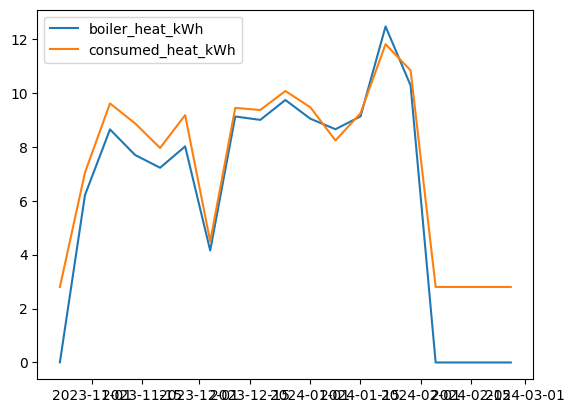

In [25]:
df = pd.concat(df_all_list, axis=1)
df = df[['water_flow_L_per_hour_mean', 'water_temperature_mean', 'boiler_wattage_mean']]
df['water_flow_L_per_hour_mean'] = df['water_flow_L_per_hour_mean']

df = df.resample('1min').mean()
df[f"consumed_heat_kJ"] = (
            df[f"water_flow_L_per_hour_mean"]
            * (df[f"water_temperature_mean"] - 10)
            * 4.186
            * 0.6
            
            
        )
df['boiler_wattage_kWh'] = df['boiler_wattage_mean'] / (1000*60)
df = df.groupby(pd.Grouper(freq='7D'))
df = df.agg({'consumed_heat_kJ': 'sum', 'water_flow_L_per_hour_mean': 'mean', 'water_temperature_mean': 'mean', 'boiler_wattage_kWh': 'sum'})
        
# df consumed_heat_kJ to kWh
df[f"consumed_heat_kWh"] = df[f"consumed_heat_kJ"] / (3600)
df[f"consumed_heat_kWh"] += 0.4*7
print(df)

df['heat_loss'] = df['consumed_heat_kWh'] - df['boiler_wattage_kWh']

plt.plot( df['boiler_wattage_kWh'], label="boiler_heat_kWh")
plt.plot( df['consumed_heat_kWh'], label="consumed_heat_kWh")
plt.legend()



In [17]:

from pytz import utc
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_training_data = datetime(2024, 1, 5)
dataHandler = DataHandler(
    "localhost",
    "smart_home_formankovi",
    "root",
    "root",
    "shelly1pm_34945475a969",
    start_of_data,
)

forecast = Forecast(dataHandler)
forecast.train_model(begin_of_training=start_of_data, end_of_training=end_of_training_data)
forecast.build_model()
forecast.fit_model()





KeyboardInterrupt: 

In [ ]:
from operator import le
import pandas as pd
import numpy as np

forecast_begin_date = datetime(2024, 1, 4, 0, 0, 0) 
forecast_end_date = datetime(2024, 1, 1, 23, 59, 59)
queries = dataHandler.get_database_queries(left_time_interval=forecast_begin_date - timedelta(hours=48), right_time_interval=forecast_begin_date)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)
df_all.index = df_all.index.tz_localize(None)
df_all, _= dataHandler.transform_data_for_ml(df_all, predicted_column='longtime_mean')

forecast_future = pd.DataFrame()

current_forecast_begin_date = forecast_begin_date
current_forecast_end_date = forecast_begin_date + timedelta(minutes=30)
for i in range(0, 48):
    print("-----")

    df_predict = pd.DataFrame({'datetime': pd.date_range(current_forecast_begin_date, current_forecast_end_date, freq='30min')})
    df_predict['longtime_mean'] = 0
    df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
    df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
    df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
    df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
    df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
    df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
    # delete column datetime
    df_predict = df_predict.drop(columns='datetime')
    len_df_predict = df_predict.shape[0]
    
    
    # concar df_all and df_predict
    
    df_all = pd.concat([df_all, df_predict], axis=0)
    df_all = df_all.reset_index(drop=True)
    
    df_predict_norm = df_all.copy()
    df_predict_norm[df_all.columns] = forecast.scaler.transform(df_all)
    # create predict df with values 

    predict_gen = forecast.generator(dataframe = df_predict_norm, 
            target_name = forecast.predicted_column, 
            lookback = forecast.lookback,
            delay = forecast.delay,
            min_index = 0,
            max_index = None,
            step = 1,
            shuffle = False,
            batch_size = df_predict.shape[0])

    (X, y_truth) = next(predict_gen)

    y_pred = forecast.model.predict(X)

    # np.expand_dims(y_truth,axis=1).shape
    y_pred_inv = np.concatenate((y_pred,np.zeros((y_pred.shape[0],forecast.num_of_features))),axis=1)
    y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
    y_pred_inv = y_pred_inv[:,0]
    # set df_all last len_df_predict values to y_pred_inv
    df_all.iloc[-len_df_predict:, df_all.columns.get_loc('longtime_mean')] = y_pred_inv
    # plt.plot(df_all.iloc[-len_df_predict:, df_all.columns.get_loc('longtime_mean')], color = 'green', label = 'Predicted data')
    df_all = df_all[len_df_predict:]
    forecast_future = pd.concat([forecast_future, df_all[-len_df_predict:]], axis=0)
    forecast_future = forecast_future.reset_index(drop=True)
    
    current_forecast_begin_date = current_forecast_begin_date + timedelta(hours=0.5)
    current_forecast_end_date = current_forecast_end_date + timedelta(hours=0.5)

# df_predict = pd.DataFrame({'datetime': pd.date_range(forecast_begin_date, forecast_end_date, freq='30min')})
# df_predict['longtime_mean'] = 0
# df_predict['weekday_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
# df_predict['weekday_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.weekday / 7)
# df_predict['hour_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.hour / 24)
# df_predict['hour_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.hour / 24)
# df_predict['minute_sin'] = np.sin(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# df_predict['minute_cos'] = np.cos(2 * np.pi * df_predict['datetime'].dt.minute / 60)
# # delete column datetime
# df_predict = df_predict.set_index('datetime')
# # concar df_all and df_predict
# df_all = pd.concat([df_all, df_predict], axis=0)

-----
1/1 [==============================] - 0s 22ms/step
-----
    longtime_mean  weekday_sin  weekday_cos  hour_sin  hour_cos    minute_sin  \
0        2.604167     0.781831     0.623490  0.258819  0.965926  0.000000e+00   
1        2.604167     0.781831     0.623490  0.258819  0.965926  5.665539e-16   
2        2.604167     0.781831     0.623490  0.500000  0.866025  0.000000e+00   
3        2.604167     0.781831     0.623490  0.500000  0.866025  5.665539e-16   
4        2.622463     0.781831     0.623490  0.707107  0.707107  0.000000e+00   
..            ...          ...          ...       ...       ...           ...   
93       2.604167     0.974928    -0.222521 -0.258819  0.965926  5.665539e-16   
94       2.952038     0.433884    -0.900969  0.000000  1.000000  0.000000e+00   
95       3.191282     0.433884    -0.900969  0.000000  1.000000  5.665539e-16   
96       0.000000     0.433884    -0.900969  0.000000  1.000000  5.665539e-16   
97       0.000000     0.433884    -0.900969  

/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 10ms/step
-----
1/1 [==============================] - 0s 11ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [==============================] - 0s 15ms/step
-----
1/1 [==============================] - 0s 15ms/step
-----
1/1 [==============================] - 0s 12ms/step
-----
1/1 [===

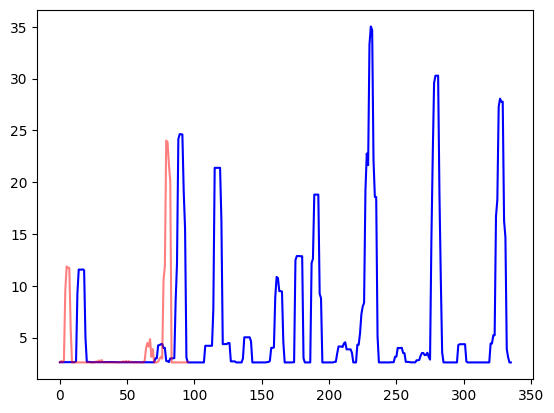

In [ ]:
test = df_all_copy['longtime_mean'].values
#add forecast_future to test
test = np.concatenate((test,forecast_future['longtime_mean'].values),axis=0)

plt.plot(df_all_copy['longtime_mean'], color = 'blue', label = 'Predicted data')
plt.plot(test[len(df_all_copy):], color = 'red', label = 'Predicted data', alpha=0.5)

In [ ]:
print(forecast_future)

    longtime_mean  weekday_sin  weekday_cos  hour_sin  hour_cos    minute_sin  \
0        2.604719     0.433884    -0.900969  0.000000  1.000000  0.000000e+00   
1        2.749697     0.433884    -0.900969  0.000000  1.000000  5.665539e-16   
2        2.604721     0.433884    -0.900969  0.000000  1.000000  5.665539e-16   
3        2.812914     0.433884    -0.900969  0.258819  0.965926  0.000000e+00   
4        9.473218     0.433884    -0.900969  0.258819  0.965926  0.000000e+00   
..            ...          ...          ...       ...       ...           ...   
91       2.604701     0.433884    -0.900969 -0.258819  0.965926  0.000000e+00   
92       2.604701     0.433884    -0.900969 -0.258819  0.965926  0.000000e+00   
93       2.604701     0.433884    -0.900969 -0.258819  0.965926  5.665539e-16   
94       2.604766     0.433884    -0.900969 -0.258819  0.965926  5.665539e-16   
95       2.670567    -0.433884    -0.900969  0.000000  1.000000  0.000000e+00   

    minute_cos  
0         

In [ ]:
print(forecast_future['longtime_mean'])

0     2.604719
1     2.749697
2     2.604721
3     2.812914
4     9.473218
        ...   
91    2.604701
92    2.604701
93    2.604701
94    2.604766
95    2.670567
Name: longtime_mean, Length: 96, dtype: float64


In [ ]:
# plt.plot(forecast_future['consumed_heat_kWh'], label="Predicted")

begin = datetime(2024, 1, 1, 0, 0, 0) 
end = datetime(2024, 1, 1, 23, 59, 59)

queries = dataHandler.get_database_queries(left_time_interval=forecast_begin_date - timedelta(days=1), right_time_interval=forecast_begin_date)
df_all = dataHandler.get_df_from_queries(queries)
df_all = dataHandler.process_kWh_water_consumption(df_all)

In [ ]:

df_all, _= dataHandler.transform_data_for_ml(df_all, predicted_column='longtime_mean')



/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"weekday"] = df.index.weekday
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"hour"] = df.index.hour
/Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy import stats

df_predict_norm = df_all.copy()
df_predict_norm[df_predict.columns] = forecast.scaler.transform(df_all)
# create predict df with values 

predict_gen = forecast.generator(dataframe = df_predict_norm, 
        target_name = forecast.predicted_column, 
        lookback = forecast.lookback,
        delay = forecast.delay,
        min_index = 0,
        max_index = None,
        step = 1,
        shuffle = False,
        batch_size = df_predict.shape[0])

(X, y_truth) = next(predict_gen)

y_pred = forecast.model.predict(X)

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate((y_pred,np.zeros((y_pred.shape[0],forecast.num_of_features))),axis=1)
y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:,0]

y_truth_inv = np.concatenate((np.expand_dims(y_truth,axis=1),np.zeros((y_truth.shape[0],forecast.num_of_features))),axis=1)
y_truth_inv = forecast.scaler.inverse_transform(y_truth_inv)
y_truth_inv = y_truth_inv[:,0]

statistics = {}
slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv,y=y_truth_inv)
mse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=True)
rmse = mean_squared_error(y_true=y_truth_inv, y_pred=y_pred_inv, squared=False)

statistics['slope'] = slope
statistics['intercept'] = intercept
statistics['r_value'] = r_value
statistics['p_value'] = p_value
statistics['std_err'] = std_err
statistics['mse'] = mse
statistics['rmse'] = rmse




1/1 [==============================] - 0s 10ms/step


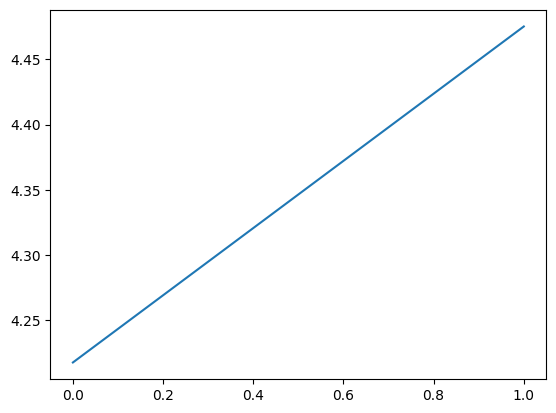

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred_inv, label="Predicted")